# 8760 Notebook

In this notebook, we’ll generate an 8760 timeseries and insert 1-in-X events into it. We'll demonstrate how to insert either the minimum, maximum, or both types of 1-in-X events. You can choose specific times to insert the events, or let the backend automatically determine the median timing based on when those events occurred in the original timeseries.

**Runtime**: Using the default settings, expect an approximate runtime of **8 min** for this notebook.

In [1]:
import numpy as np
import pandas as pd
import one_in_x_in_8760 as oix
from climakitae.util.warming_levels import get_gwl_at_year, get_year_at_gwl

# Set random seed for bootstrapping in internal one_in_x calcuations 
np.random.seed(35)

## Setup 

In [2]:
# Putting locations into a DataFrame
locations = {
    "Goleta": (34.486652, -119.894310),
    "Isla Vista": (34.427741, -119.855950),
    "Santa Barbara Mountains": (34.518453, -119.799645),
    "Valencia": (34.432468, -118.571098),
    "Castaic": (34.492141, -118.605053),
    "Lebec": (34.680102, -118.789246),
}

df = pd.DataFrame.from_dict(locations, orient='index', columns=['lat', 'lon']).reset_index()
df.rename(columns={'index': 'location'}, inplace=True)

# Santa Barbara area
sb = df.iloc[:3][['lat', 'lon']]
sb_locs = ['Goleta', 'Isla Vista', 'Santa Barbara Mountains']

# Santa Clarita area
sc = df.iloc[3:6][['lat', 'lon']]
sc_locs = ['Valencia', 'Castaic', 'Lebec']

In [3]:
# Set params for 1-in-X calculations
one_in_x = np.array([10, 100])
event_duration = (1, 'day')
distr = 'gev'

## Introduction of Custom WLs

In this version, we will introduce custom warming levels, and a tool to help you find a custom WL appropriate for your planning processes.

Below, you'll see how to use two functions that translate between years and GWLs.

**An important note:**
In order to use the SSP parameter for the following functions, the SSP values need to be one (or more) of the following:

```
"Historical", "SSP 1-1.9", "SSP 1-2.6", "SSP 2-4.5", "SSP 3-7.0", "SSP 5-8.5", or "all"
```

The bounds of the potential warming levels are from 0 to 5.702 for WRF, and the bounds of the valid years are from 1950-2100.

#### Examples

In this first example, we will use `get_gwl_at_year` to find the WL associated with a given year for SSP 3-7.0.

In [4]:
get_gwl_at_year(2020, ssp="SSP 3-7.0")

,5%,Mean,95%
SSP 3-7.0,1.09,1.22,1.37


You can additionally pass in a year and get back GWLs across all SSPs.

In [5]:
get_gwl_at_year(2050, ssp="all")

,5%,Mean,95%
SSP 1-1.9,1.26,1.57,1.92
SSP 1-2.6,1.39,1.72,2.16
SSP 2-4.5,1.61,1.95,2.40
SSP 3-7.0,1.74,2.10,2.56
SSP 5-8.5,1.90,2.35,2.87


If you're interested in knowing what year is associated with a given warming level, you can do the reverse, with `get_year_at_gwl`.

In [6]:
get_year_at_gwl(2.1, ssp="SSP 3-7.0")

,5%,Mean,95%
SSP 3-7.0,2040,2050,2065


And the same `all` SSP argument if you wanted to see all SSPs.

In [7]:
get_year_at_gwl(2.1, ssp="all")

,5%,Mean,95%
Historical,<NA>,<NA>,<NA>
SSP 1-1.9,<NA>,<NA>,<NA>
SSP 1-2.6,<NA>,<NA>,<NA>
SSP 2-4.5,2042,2057,2092
SSP 3-7.0,2040,2050,2065
SSP 5-8.5,2036,2045,2057


You'll notice that the above DataFrame returns NaNs for certain SSPs, this is because those SSPs don't have any GCMs that reach that given level of warming.

In [8]:
# Example with a really high WL
get_year_at_gwl(6.7, ssp="all")

,5%,Mean,95%
Historical,<NA>,<NA>,<NA>
SSP 1-1.9,<NA>,<NA>,<NA>
SSP 1-2.6,<NA>,<NA>,<NA>
SSP 2-4.5,<NA>,<NA>,<NA>
SSP 3-7.0,<NA>,<NA>,<NA>
SSP 5-8.5,<NA>,<NA>,<NA>


From here, you can decide how you'd like to aggregate the WL values across the SSPs from the returned table from `get_gwl_at_year`. Then, you can pass in that WL value to the following `retrieve_data` function to get custom WL data!

## Reading/Loading WL Data

In [9]:
### Retrieving saved files for SB/SC locations, or generating the data from scratch if not available locally
sb_files = [
#     'one_in_10-100_temperature_raw_data_34495N_-119882W.nc',
#     'one_in_10-100_temperature_raw_data_34434N_-11987W.nc',
#     'one_in_10-100_temperature_raw_data_3452N_-119782W.nc'
]
sc_files = [
#     'one_in_10-100_temperature_raw_data_34425N_-118559W.nc',
#     'one_in_10-100_temperature_raw_data_34492N_-118616W.nc',
#     'one_in_10-100_temperature_raw_data_34695N_-118788W.nc',
]

# Pass in custom parameters
clean_raw_data_sb = oix.retrieve_data(
    sb_locs, 
    sb, 
    sb_files, 
    'SB', 
    hour_offset=7, # Offset hours from UTC to a different timezone (-7 to PST)
    warming_level=3.14159 # Pass in a custom WL here!
)
clean_raw_data_sc = oix.retrieve_data(
    sc_locs, 
    sc, 
    sc_files, 
    'SC', 
    hour_offset=7, 
    warming_level=2.71818
)

Attempting to load saved SB files...
Falling back to cava_data for SB due to error: no files to open
Using `cava_data` to fetch SB data instead...
Calculating 1-in-10 year, 1-day Max Air Temperature at 2m for all seasons for Warming Level 3.142°C and 1-in-100 year, 1-day Max Air Temperature at 2m for all seasons for Warming Level 3.142°C
--- Selecting Data Points --- 

Selecting data for (34.486652, -119.89431)


/home/jovyan/src/climakitae/climakitae/util/utils.py:1422: UserWarning: 

Incomplete warming level for WRF_MIROC6_r1i1p1f1 at 3.14159C. 
Skipping this warming level.
  warnings.warn(


Selecting data for (34.427741, -119.85595)


/home/jovyan/src/climakitae/climakitae/util/utils.py:1422: UserWarning: 

Incomplete warming level for WRF_MIROC6_r1i1p1f1 at 3.14159C. 
Skipping this warming level.
  warnings.warn(


Selecting data for (34.518453, -119.799645)


/home/jovyan/src/climakitae/climakitae/util/utils.py:1422: UserWarning: 

Incomplete warming level for WRF_MIROC6_r1i1p1f1 at 3.14159C. 
Skipping this warming level.
  warnings.warn(



--- Loading Data into Memory ---

Point (34.49457931518555, -119.88214111328125)
Processing data to read 7.02 MB of data into memory... 
[########################################] | 100% Completed | 51.33 s
Complete!
Point (34.433998107910156, -119.87033081054688)
Processing data to read 7.02 MB of data into memory... 
[########################################] | 100% Completed | 46.61 s
Complete!
Point (34.5202751159668, -119.78153991699219)
Processing data to read 7.02 MB of data into memory... 
[########################################] | 100% Completed | 46.89 s
Complete!

--- Exporting Raw Data ---
Exporting specified data to NetCDF...
Saving file locally as NetCDF4...
File one_in_10-100_temperature_raw_data_34-494579N_119-882141W.nc exists. Please either delete that file from the work space or specify a new file name here.
Exporting specified data to NetCDF...
Saving file locally as NetCDF4...
File one_in_10-100_temperature_raw_data_34-433998N_119-870331W.nc exists. Please eithe

### Calculating 1-in-X events

In [10]:
# Calculating the 1-in-X return values, and lower + upper CIs, for SB locations
all_one_in_x_sb = oix.get_one_in_x(clean_raw_data_sb, one_in_x, event_duration, distr, 'max')
calc_data_sb = all_one_in_x_sb['return_value']

In [11]:
# Calculating the 1-in-X return values, and lower + upper CIs, for SC locations
all_one_in_x_sc = oix.get_one_in_x(clean_raw_data_sc, one_in_x, event_duration, distr, 'max')
calc_data_sc = all_one_in_x_sc['return_value']

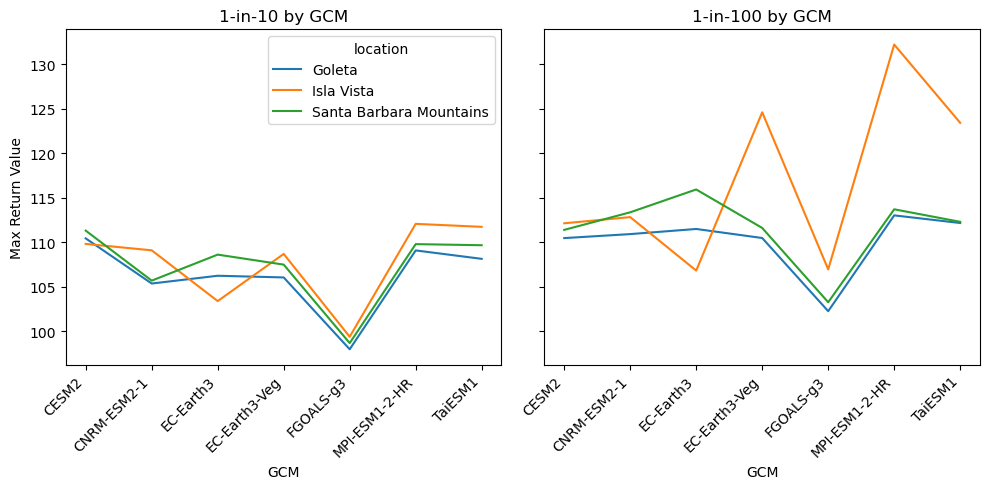

In [12]:
# Plotting the 1-in-X values by simulation for Santa Barbara locations
oix.plot_retvals(calc_data_sb)

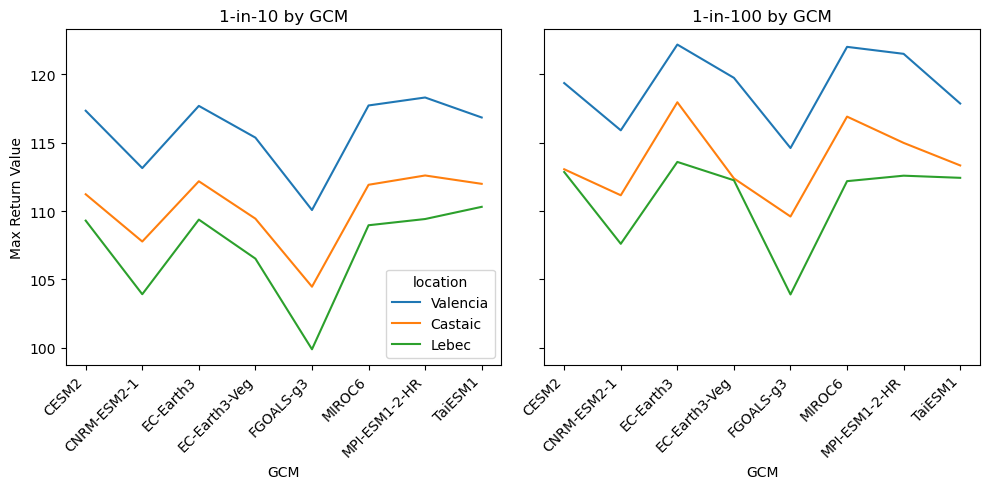

In [13]:
# Plotting the 1-in-X values by simulation for Santa Clarita locations
oix.plot_retvals(calc_data_sc)

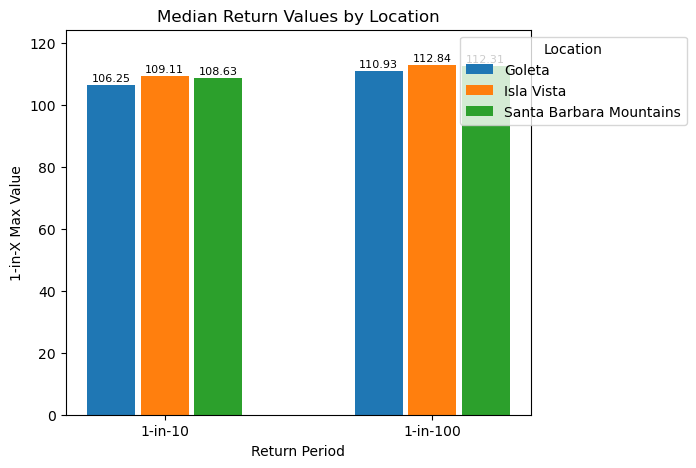

In [14]:
# Finding the median of the above plots along simulation dimension
oix.plot_med_val_by_locs(calc_data_sb)

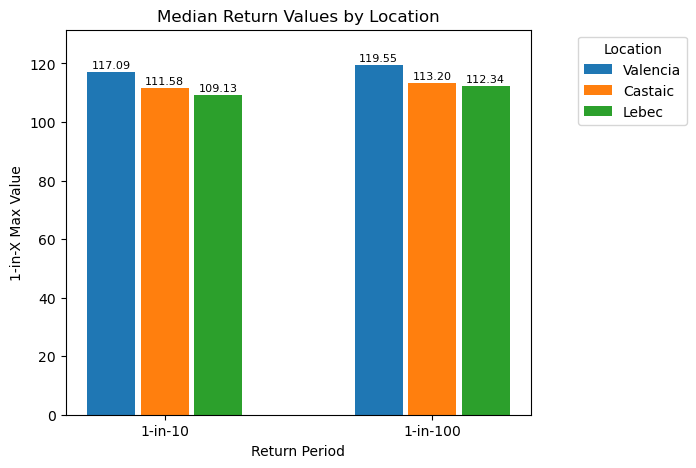

In [15]:
oix.plot_med_val_by_locs(calc_data_sc)

# Inserting `time` amount of 1-in-X timesteps into 8760s

### Setting a number of +/- days for `ramp up` and `ramp down`, creating modified 8760s, and plotting them 

In [16]:
# Setting param for number of +/- number of days to 'ramp up' and 'ramp down' by
t = 14

#### Here, we will look into how you can create a `modified8760` using the calculated median times to insert these 1-in-X events, and using the times that a user passes in.

#### 1. Using calculated median times to insert 1-in-X events into

#### 1. Using calculated median times to insert 1-in-X events into

No valid times found for location=Isla Vista, simulation=WRF_MPI-ESM1-2-HR_r3i1p1f1_historical+ssp370, one_in_x=100; returning an empty DataArray.



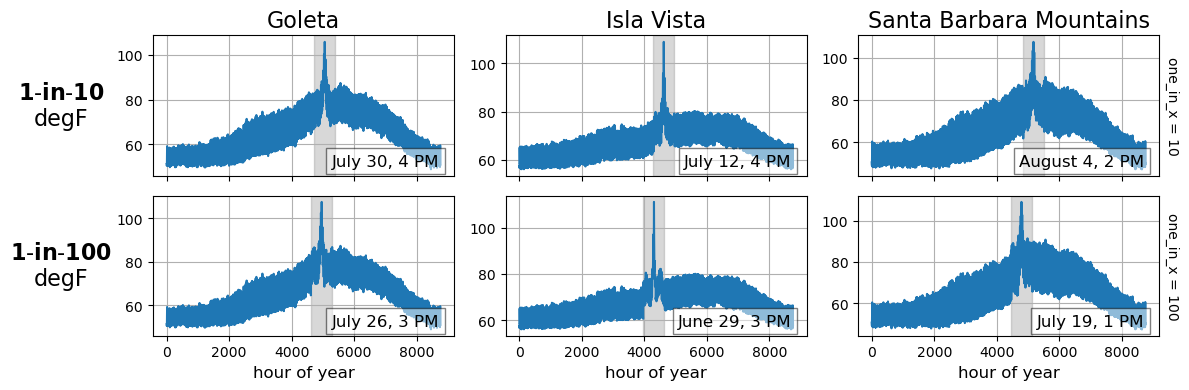

In [17]:
# Create a modified 8760 that injects 1-in-X events into the median times these events occur by location
modified8760_sb, insert_times = oix.create_modified_8760(clean_raw_data_sb, all_one_in_x_sb, t)
oix.plot_modified8760s(modified8760_sb, insert_times, t)

#### 2. Insert 1-in-X events at times that users pre-define

In [18]:
# This creates a dummy DataArray that follows the data shape needed to specify custom times
dummy_times = oix.create_empty_da(all_one_in_x_sb['return_value'], keep_dims=['location', 'one_in_x'])

In [19]:
# Here, you can manually change the values from `custom_times` to set specific times for these `one_in_x` events to occur.
# `updates` can either be a list of dictionaries (if you're looking to set these different events at different times, or you can
# set `updates` to a singular number to have all the events be inserted at the same time

updates = [
    {'location': 'Goleta', 'one_in_x': 10, 'value': 1000},
    {'location': 'Isla Vista', 'one_in_x': 100, 'value': 1000}
]

# OR YOU CAN DO
updates = 3015

custom_times = oix.set_custom_times(dummy_times, updates)

No valid times found for location=Isla Vista, simulation=WRF_MPI-ESM1-2-HR_r3i1p1f1_historical+ssp370, one_in_x=100; returning an empty DataArray.



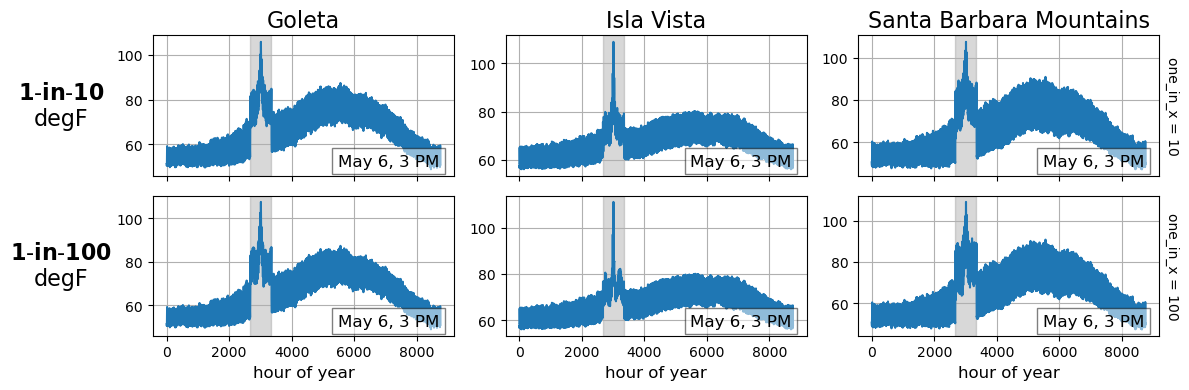

In [20]:
# Calculates the modified 8760 with 1-in-X events inserted at custom times
modified8760_sb, insert_times = oix.create_modified_8760(clean_raw_data_sb, all_one_in_x_sb, t, custom_times=custom_times)
oix.plot_modified8760s(modified8760_sb, insert_times, t)

## Inserting a min 1-in-X event into already modified 8760

Here, we will go through inserting another 1-in-X event into an already modified 8760, to showcase an 8760 timeseries with both a 1-in-X max temp and a 1-in-X min event inserted.

In [21]:
# Calculating the 1-in-X min events,, and lower + upper CIs, for SB locations
sb_one_in_x_min = oix.get_one_in_x(clean_raw_data_sb, one_in_x, event_duration, distr, 'min')

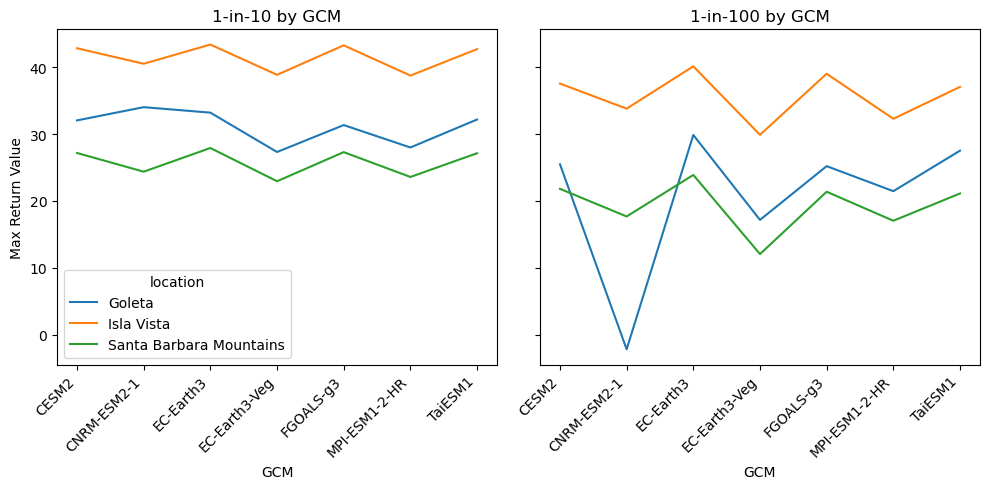

In [22]:
# Plotting the 1-in-X values by simulation for Santa Barbara locations
oix.plot_retvals(sb_one_in_x_min['return_value'])

In [23]:
# Custom inserting events at hour=1000
updates = 1000
custom_times = oix.set_custom_times(dummy_times, updates)

In [24]:
# Insert a min 1-in-X event into already modified 8760
two_events_8760_sb, insert_times = oix.create_modified_8760(
    clean_raw_data_sb,
    sb_one_in_x_min, 
    t, 
    extremes_type='min', 
    # custom_times=custom_times, # Comment this out if you'd like the back-end to auto-calculate the median time to insert these events
    custom_8760=modified8760_sb
)

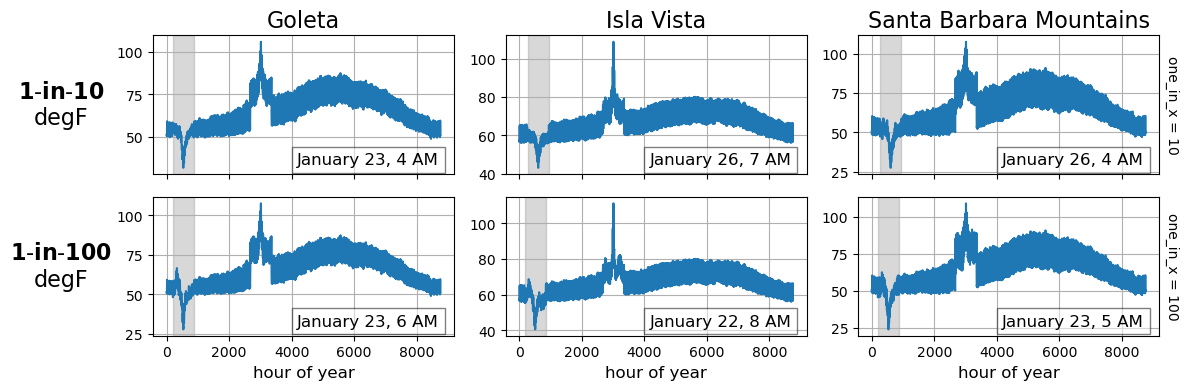

In [25]:
# Plot 8760 with 2 types of 1-in-X events inserted
oix.plot_modified8760s(two_events_8760_sb, insert_times, t)

### Do the same for SC, but at hour=6000

In [26]:
# Create `dummy_times` DataArray for SC
dummy_times = oix.create_empty_da(all_one_in_x_sc['return_value'], keep_dims=['location', 'one_in_x'])

In [27]:
# Modify event timing here
updates = 6000
custom_times = oix.set_custom_times(dummy_times, updates)

No valid times found for location=Valencia, simulation=WRF_EC-Earth3-Veg_r1i1p1f1_historical+ssp370, one_in_x=100; returning an empty DataArray.



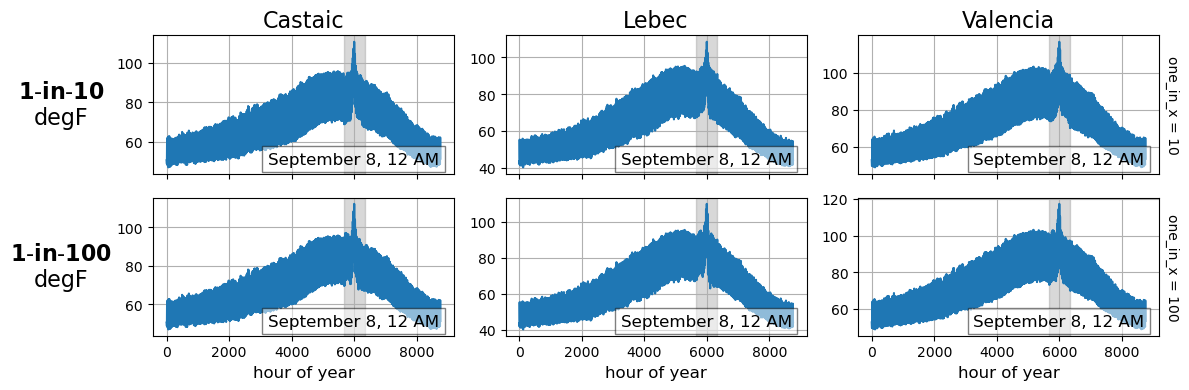

In [28]:
# Create and plot modified 8760 for SC
modified8760_sc, insert_times = oix.create_modified_8760(clean_raw_data_sc, all_one_in_x_sc, t, custom_times=custom_times)
oix.plot_modified8760s(modified8760_sc, insert_times, t)